# Bayesian Deep Learning 

In [1]:
import torch
from torch import nn
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Nice dark plotting settings
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [52]:
# Load C++ extensions
bnets = load(name='bayesian_nets',
             sources=['bayesian_nets.cc'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++1z'],
             verbose=False)

In [6]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(1, 10, bias = True)
        self.l2 = nn.Linear(10, 10, bias = True)
        self.l3 = nn.Linear(10, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        return x

net = Net()
jit_net = torch.jit.script(net)
jit_net.save('jit_net.pt')

In [42]:
n_tr = 6
n_val = 300

x_train, y_train, x_val, y_val = bnets.generate_data(n_tr, n_val)

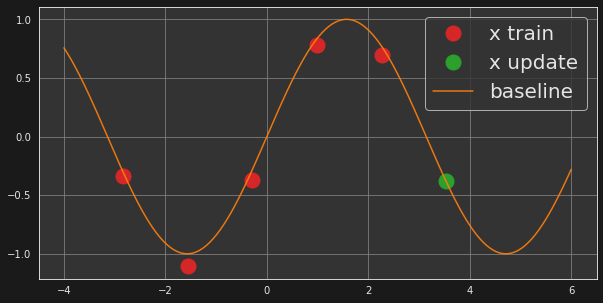

In [43]:
plt.figure(figsize=(10,5))
plt.plot(x_train[:-1].numpy(), y_train[:-1].numpy(),'.C3',markersize=30, label='x train')
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='baseline')

plt.legend(fontsize=20)
plt.show()

In [53]:
[optim_params, adam_preds] = bnets.train_jit_module('jit_net.pt', x_train[:-1], y_train[:-1], x_val, 250)

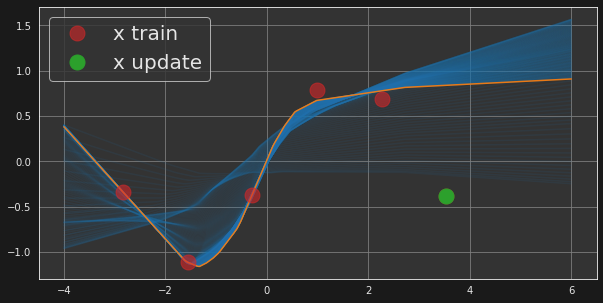

In [54]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), adam_preds.numpy().squeeze().T, 'C0',alpha=0.1)
plt.plot(x_val.numpy(), adam_preds[-1].numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')
plt.legend(fontsize=20)
plt.show()

In [84]:
sample = bnets.sample_jit_module('jit_net.pt', 'ghmc_sample_bayesian_net.pt', optim_params, x_train[-1:], y_train[-1:], 0.01, 100, 5, 0.01, 0.005, 10.0)

In [85]:
posterior_mean_pred = bnets.compute_posterior_mean_prediction('jit_net.pt', x_val, sample, 3) 
bayes_pred = bnets.compute_bayes_predictions('jit_net.pt', x_val, sample) 

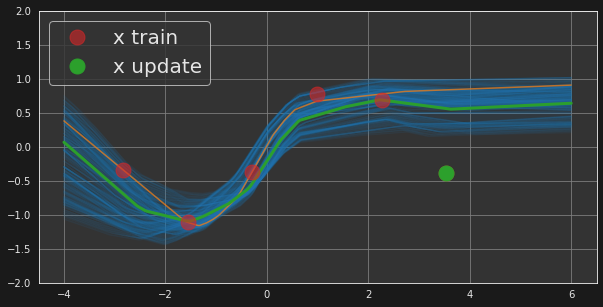

In [88]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), bayes_pred.numpy().squeeze().T, 'C0',alpha=0.1)
plt.plot(x_val.numpy(), adam_preds[-1].numpy().squeeze().T, 'C1',alpha=0.7)
plt.plot(x_val.numpy(), posterior_mean_pred.numpy().squeeze().T, 'C2',alpha=0.99, linewidth=3)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.plot(x_train[-1:].numpy(), y_train[-1:].numpy(),'.C2',markersize=30, label='x update')

plt.legend(fontsize=20)
plt.ylim([-2,2])
plt.show()